In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Subset
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset


# 1) Selected 5 Classes
selected_classes = [
    "Impressionism",
    "Realism",
    "Expressionism",
    "Romanticism",
    "Post_Impressionism"
]



# --- Enhanced Data Augmentation for Training ---
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomRotation(5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Standard Transform for Validation/Test ---
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Load Dataset ---
dataset = datasets.ImageFolder("/kaggle/input/wikiart", transform=None)


# 4) Filter Dataset to Selected Classes Only
# =====================================================
class_to_idx = dataset.class_to_idx

selected_class_indices = [
    class_to_idx[c] for c in selected_classes if c in class_to_idx
]

filtered_indices = [
    i for i, (_, label) in enumerate(dataset.samples)
    if label in selected_class_indices
]

filtered_dataset = Subset(dataset, filtered_indices)

print(f"Filtered dataset size: {len(filtered_dataset)}")
print(f"Number of selected classes: {len(selected_class_indices)}")



all_indices = list(range(len(filtered_dataset)))

all_labels = [
    filtered_dataset.dataset.samples[idx][1]
    for idx in filtered_dataset.indices
]

# 6) Stratified Split (80 / 10 / 10)
# =====================================================
train_idx, temp_idx, train_labels, temp_labels = train_test_split(
    all_indices,
    all_labels,
    test_size=0.2,
    stratify=all_labels,
    random_state=42
)

val_idx, test_idx, _, _ = train_test_split(
    temp_idx,
    temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

train_ds = Subset(filtered_dataset, train_idx)
val_ds   = Subset(filtered_dataset, val_idx)
test_ds  = Subset(filtered_dataset, test_idx)


# 6) Remap labels 0..14
old_to_new = {old_idx: new_idx for new_idx, old_idx in enumerate(selected_class_indices)}

class RemappedDataset(Dataset):
    def __init__(self, subset, old_to_new, transform=None):
        self.subset = subset
        self.old_to_new = old_to_new
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, old_label = self.subset[idx]
        new_label = self.old_to_new[old_label]
        if self.transform:
            img = self.transform(img)

        return img, new_label



# Apply transforms
train_ds = RemappedDataset(train_ds, old_to_new, transform=train_transform)
val_ds   = RemappedDataset(val_ds, old_to_new, transform=val_test_transform)
test_ds  = RemappedDataset(test_ds, old_to_new, transform=val_test_transform)


# --- Optimized DataLoader for Multi-GPU Training ---
# Calculate optimal batch size for 2 GPUs
BATCH_SIZE = 64  # Split across 2 GPUs (64 per GPU) - increase to 256 if memory allows

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,  # 2 workers per GPU
    pin_memory=True,  # Faster CPU-to-GPU transfer
    prefetch_factor=3,  # Prefetch 3 batches per worker
    persistent_workers=True  # Reuse workers between epochs
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=3,
    persistent_workers=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=3,
    persistent_workers=True
)

# =====================================================
print(f"Train size: {len(train_ds)}")
print(f"Val size: {len(val_ds)}")
print(f"Test size: {len(test_ds)}")
print("Classes used:")
for c in selected_classes:
    print("-", c)
print(f"Batch size: {BATCH_SIZE} (split across 2 GPUs)")
print(f"Workers: 4 (2 per GPU)")
print("DataLoader optimized for maximum throughput!")

Filtered dataset size: 43998
Number of selected classes: 5
Train size: 35198
Val size: 4400
Test size: 4400
Classes used:
- Impressionism
- Realism
- Expressionism
- Romanticism
- Post_Impressionism
Batch size: 64 (split across 2 GPUs)
Workers: 4 (2 per GPU)
DataLoader optimized for maximum throughput!


In [2]:
from collections import Counter


selected_class_names = selected_classes


labels = [
    filtered_dataset.dataset.samples[idx][1]
    for idx in filtered_dataset.indices
]


label_counts = Counter(labels)


idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

print("\nNums of imgs for each selected class:")
for idx, count in label_counts.items():
    print(f"{idx_to_class[idx]}: {count}")



Nums of imgs for each selected class:
Expressionism: 6736
Impressionism: 13060
Post_Impressionism: 6450
Realism: 10733
Romanticism: 7019


In [3]:
total_images = len(filtered_dataset)

print("\n% of each class in filtered data:")
for idx, count in label_counts.items():
    class_name = idx_to_class[idx]
    print(f"{class_name}: {count / total_images * 100:.2f}%")



% of each class in filtered data:
Expressionism: 15.31%
Impressionism: 29.68%
Post_Impressionism: 14.66%
Realism: 24.39%
Romanticism: 15.95%


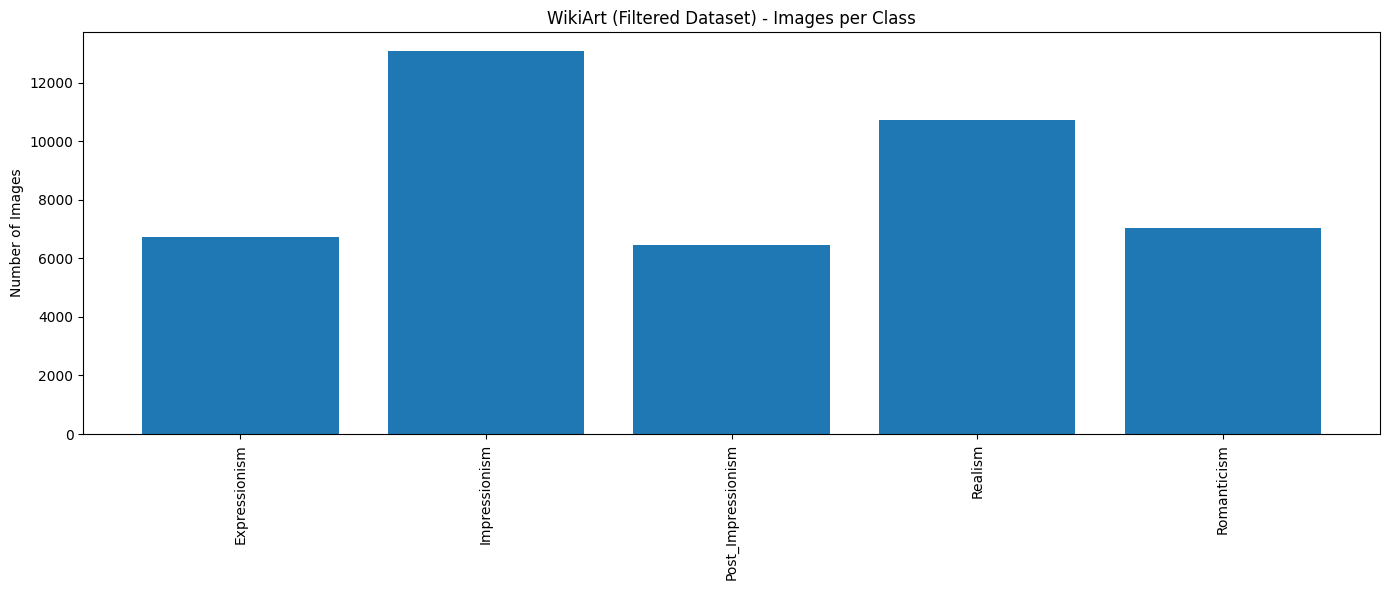

In [4]:
import matplotlib.pyplot as plt

classes = []
counts = []

for idx, count in label_counts.items():
    classes.append(idx_to_class[idx])
    counts.append(count)

plt.figure(figsize=(14,6))
plt.bar(classes, counts)
plt.xticks(rotation=90)
plt.ylabel("Number of Images")
plt.title("WikiArt (Filtered Dataset) - Images per Class")
plt.tight_layout()
plt.show()


In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.optim as optim
from collections import Counter
import torch.nn.functional as F

In [7]:
for inputs, labels in train_loader:
    print(labels.max(), labels.min())  # لازم يبقى من 0 لـ 14 بس
    break

tensor(4) tensor(0)


In [8]:
import torch

class_counts = [label_counts[old_idx] for old_idx in old_to_new.keys()]
total_count = sum(class_counts)

class_weights = [total_count / (len(class_counts) * count) for count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float)

if torch.cuda.is_available():
    class_weights = class_weights.cuda()

print("Class weights:")
print(class_weights)


Class weights:
tensor([0.6738, 0.8199, 1.3064, 1.2537, 1.3643], device='cuda:0')


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from torchvision.transforms.v2 import CutMix, MixUp
from torch.cuda.amp import GradScaler, autocast

# --- Settings ---
num_epochs = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = len(selected_classes)  # 15

# --- Model ---
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = True

model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, num_classes)
)


model = model.to(device)

# --- Multi-GPU ---
num_gpus = torch.cuda.device_count()
if num_gpus > 1:
    print(f"Using DataParallel across {num_gpus} GPUs")
    model = nn.DataParallel(model)

# --- Loss, Optimizer, Scheduler ---
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.1)
optimizer = torch.optim.AdamW([
    {"params": model.module.conv1.parameters(), "lr": 1e-5},
    {"params": model.module.bn1.parameters(), "lr": 1e-5},
    {"params": model.module.layer1.parameters(), "lr": 1e-5},
    {"params": model.module.layer2.parameters(), "lr": 1e-5},
    {"params": model.module.layer3.parameters(), "lr": 2e-5},
    {"params": model.module.layer4.parameters(), "lr": 5e-5},
    {"params": model.module.fc.parameters(), "lr": 1e-4} # سرعة أعلى للرأس
], weight_decay=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
scaler = GradScaler()

# --- Mixed precision ---
scaler = GradScaler()

# --- Training Loop ---
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    print(f"\nEpoch {epoch+1}/{num_epochs} Started...")
    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", unit="batch")
    
    for inputs, labels in progress_bar:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        acc_value = 100 * correct / total if total > 0 else 0.0
        progress_bar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{acc_value:.2f}%"
        })

    # Training metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct / total if total > 0 else 0.0

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = 100 * val_correct / val_total if val_total > 0 else 0.0

    # --- Test ---
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    epoch_test_loss = test_loss / len(test_loader.dataset)
    epoch_test_acc = 100 * test_correct / test_total if test_total > 0 else 0.0

    # --- Save Checkpoint ---
    save_path = f"/kaggle/working/epoch_{epoch}.pt"
    model_to_save = model.module if isinstance(model, nn.DataParallel) else model
    torch.save({
        'epoch': epoch,
        'model_state_dict': model_to_save.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'loss': epoch_loss,
    }, save_path)
    print(f"Saved: {save_path}")

    # Scheduler step
    scheduler.step()

    # --- Summary ---
    print(f"Summary → "
          f"Train Acc: {epoch_acc:.2f}% | Train Loss: {epoch_loss:.4f} | "
          f"Val Acc: {epoch_val_acc:.2f}% | Val Loss: {epoch_val_loss:.4f} | "
          f"Test Acc: {epoch_test_acc:.2f}% | Test Loss: {epoch_test_loss:.4f}")

print("Training Complete!")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s] 
/tmp/ipykernel_47/169286044.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_47/169286044.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Using DataParallel across 2 GPUs

Epoch 1/20 Started...


Training Epoch 1:   0%|          | 0/550 [00:00<?, ?batch/s]/tmp/ipykernel_47/169286044.py:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training Epoch 1: 100%|██████████| 550/550 [09:17<00:00,  1.01s/batch, loss=1.1700, acc=51.82%]
/tmp/ipykernel_47/169286044.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_47/169286044.py:120: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Saved: /kaggle/working/epoch_0.pt
Summary → Train Acc: 51.82% | Train Loss: 1.2560 | Val Acc: 63.18% | Val Loss: 1.0807 | Test Acc: 62.66% | Test Loss: 1.0865

Epoch 2/20 Started...


Training Epoch 2: 100%|██████████| 550/550 [08:44<00:00,  1.05batch/s, loss=1.0286, acc=62.78%]


Saved: /kaggle/working/epoch_1.pt
Summary → Train Acc: 62.78% | Train Loss: 1.0847 | Val Acc: 65.32% | Val Loss: 1.0292 | Test Acc: 63.93% | Test Loss: 1.0367

Epoch 3/20 Started...


Training Epoch 3: 100%|██████████| 550/550 [08:48<00:00,  1.04batch/s, loss=1.0252, acc=66.81%]


Saved: /kaggle/working/epoch_2.pt
Summary → Train Acc: 66.81% | Train Loss: 1.0169 | Val Acc: 67.14% | Val Loss: 0.9975 | Test Acc: 66.41% | Test Loss: 1.0109

Epoch 4/20 Started...


Training Epoch 4: 100%|██████████| 550/550 [08:51<00:00,  1.04batch/s, loss=1.0168, acc=69.46%]


Saved: /kaggle/working/epoch_3.pt
Summary → Train Acc: 69.46% | Train Loss: 0.9668 | Val Acc: 67.82% | Val Loss: 0.9858 | Test Acc: 67.52% | Test Loss: 1.0077

Epoch 5/20 Started...


Training Epoch 5: 100%|██████████| 550/550 [08:45<00:00,  1.05batch/s, loss=1.0128, acc=72.12%]


Saved: /kaggle/working/epoch_4.pt
Summary → Train Acc: 72.12% | Train Loss: 0.9243 | Val Acc: 69.14% | Val Loss: 0.9809 | Test Acc: 68.25% | Test Loss: 0.9946

Epoch 6/20 Started...


Training Epoch 6: 100%|██████████| 550/550 [08:55<00:00,  1.03batch/s, loss=1.0853, acc=74.59%]


Saved: /kaggle/working/epoch_5.pt
Summary → Train Acc: 74.59% | Train Loss: 0.8839 | Val Acc: 70.09% | Val Loss: 0.9833 | Test Acc: 69.52% | Test Loss: 0.9887

Epoch 7/20 Started...


Training Epoch 7: 100%|██████████| 550/550 [08:49<00:00,  1.04batch/s, loss=0.8517, acc=76.79%]


Saved: /kaggle/working/epoch_6.pt
Summary → Train Acc: 76.79% | Train Loss: 0.8480 | Val Acc: 69.43% | Val Loss: 0.9866 | Test Acc: 69.20% | Test Loss: 0.9924

Epoch 8/20 Started...


Training Epoch 8: 100%|██████████| 550/550 [08:43<00:00,  1.05batch/s, loss=0.6954, acc=78.67%]


Saved: /kaggle/working/epoch_7.pt
Summary → Train Acc: 78.67% | Train Loss: 0.8118 | Val Acc: 71.20% | Val Loss: 0.9802 | Test Acc: 70.11% | Test Loss: 1.0014

Epoch 9/20 Started...


Training Epoch 9: 100%|██████████| 550/550 [08:45<00:00,  1.05batch/s, loss=0.6735, acc=80.62%]


Saved: /kaggle/working/epoch_8.pt
Summary → Train Acc: 80.62% | Train Loss: 0.7808 | Val Acc: 70.52% | Val Loss: 0.9931 | Test Acc: 70.02% | Test Loss: 1.0087

Epoch 10/20 Started...


Training Epoch 10: 100%|██████████| 550/550 [08:52<00:00,  1.03batch/s, loss=0.7957, acc=82.13%]


Saved: /kaggle/working/epoch_9.pt
Summary → Train Acc: 82.13% | Train Loss: 0.7540 | Val Acc: 70.55% | Val Loss: 0.9920 | Test Acc: 70.07% | Test Loss: 1.0155

Epoch 11/20 Started...


Training Epoch 11: 100%|██████████| 550/550 [08:42<00:00,  1.05batch/s, loss=0.7312, acc=83.47%]


Saved: /kaggle/working/epoch_10.pt
Summary → Train Acc: 83.47% | Train Loss: 0.7304 | Val Acc: 71.20% | Val Loss: 1.0081 | Test Acc: 70.02% | Test Loss: 1.0273

Epoch 12/20 Started...


Training Epoch 12: 100%|██████████| 550/550 [08:50<00:00,  1.04batch/s, loss=0.6654, acc=84.64%]


Saved: /kaggle/working/epoch_11.pt
Summary → Train Acc: 84.64% | Train Loss: 0.7103 | Val Acc: 71.48% | Val Loss: 1.0101 | Test Acc: 70.14% | Test Loss: 1.0292

Epoch 13/20 Started...


Training Epoch 13: 100%|██████████| 550/550 [08:53<00:00,  1.03batch/s, loss=0.8020, acc=85.92%]


Saved: /kaggle/working/epoch_12.pt
Summary → Train Acc: 85.92% | Train Loss: 0.6885 | Val Acc: 71.86% | Val Loss: 1.0164 | Test Acc: 70.02% | Test Loss: 1.0381

Epoch 14/20 Started...


Training Epoch 14: 100%|██████████| 550/550 [08:46<00:00,  1.04batch/s, loss=0.6196, acc=86.48%]


Saved: /kaggle/working/epoch_13.pt
Summary → Train Acc: 86.48% | Train Loss: 0.6774 | Val Acc: 71.41% | Val Loss: 1.0167 | Test Acc: 69.93% | Test Loss: 1.0423

Epoch 15/20 Started...


Training Epoch 15: 100%|██████████| 550/550 [08:54<00:00,  1.03batch/s, loss=0.7165, acc=87.15%]


Saved: /kaggle/working/epoch_14.pt
Summary → Train Acc: 87.15% | Train Loss: 0.6640 | Val Acc: 71.25% | Val Loss: 1.0156 | Test Acc: 70.18% | Test Loss: 1.0403

Epoch 16/20 Started...


Training Epoch 16: 100%|██████████| 550/550 [08:50<00:00,  1.04batch/s, loss=0.5711, acc=87.58%]


Saved: /kaggle/working/epoch_15.pt
Summary → Train Acc: 87.58% | Train Loss: 0.6588 | Val Acc: 72.23% | Val Loss: 1.0208 | Test Acc: 70.68% | Test Loss: 1.0415

Epoch 17/20 Started...


Training Epoch 17: 100%|██████████| 550/550 [08:52<00:00,  1.03batch/s, loss=0.6414, acc=87.98%]


Saved: /kaggle/working/epoch_16.pt
Summary → Train Acc: 87.98% | Train Loss: 0.6530 | Val Acc: 71.32% | Val Loss: 1.0242 | Test Acc: 69.66% | Test Loss: 1.0493

Epoch 18/20 Started...


Training Epoch 18: 100%|██████████| 550/550 [08:51<00:00,  1.03batch/s, loss=0.5891, acc=88.72%]


Saved: /kaggle/working/epoch_17.pt
Summary → Train Acc: 88.72% | Train Loss: 0.6433 | Val Acc: 72.09% | Val Loss: 1.0227 | Test Acc: 70.43% | Test Loss: 1.0498

Epoch 19/20 Started...


Training Epoch 19: 100%|██████████| 550/550 [08:56<00:00,  1.02batch/s, loss=0.5998, acc=88.80%]


Saved: /kaggle/working/epoch_18.pt
Summary → Train Acc: 88.80% | Train Loss: 0.6424 | Val Acc: 71.93% | Val Loss: 1.0190 | Test Acc: 70.32% | Test Loss: 1.0457

Epoch 20/20 Started...


Training Epoch 20: 100%|██████████| 550/550 [08:52<00:00,  1.03batch/s, loss=0.6654, acc=88.72%]


Saved: /kaggle/working/epoch_19.pt
Summary → Train Acc: 88.72% | Train Loss: 0.6407 | Val Acc: 71.25% | Val Loss: 1.0236 | Test Acc: 69.75% | Test Loss: 1.0493
Training Complete!


In [ ]:
from tqdm import tqdm
import torch

# 1) Load checkpoint
checkpoint = torch.load("/kaggle/working/epoch_15.pt")

# 2) Load same model architecture
model = models.resnet18(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.classes))
model = model.cuda()

# 3) Fix DataParallel keys
state_dict = checkpoint["model_state_dict"]
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

model.load_state_dict(new_state_dict)
model.eval()

# 4) Validation accuracy with progress bar
correct = 0
total = 0

print("\n Starting Validation...\n")

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Validating", unit="batch"):
        imgs, labels = imgs.cuda(), labels.cuda()
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

acc = correct / total * 100
print(f"\n Final Validation Accuracy = {acc:.2f}%")

In [12]:
print(type(model))


<class 'torch.nn.parallel.data_parallel.DataParallel'>
